This notebook runs Lume-Impact.  Updated 2024-02-21

# Import statements

In [60]:
import numpy as np
from distgen import Generator
from impact import Impact, run_impact_with_distgen, evaluate_impact_with_distgen
from impact.autophase import autophase_and_scale
import os
from pmd_beamphysics import single_particle

%run -i helper_funcs.py


# Define Inputs

In [61]:
NAME = 'test_run_16_PR10571'
FILEPATH='/sdf/group/ad/beamphysics/cropp/LUME-IMPACT/Solenoid_Scan/' 

Sim_End='PR10571' # Can be PR10241, L0AFEND or PR10571

GFILE = os.path.expandvars('distgen.yaml')
# YFILE = os.path.expandvars('ImpactT.yaml')


SETTINGS0 = {
    'numprocs':100,
    'header:Nx':64,
    'header:Ny':64,  
    'header:Nz':64, 
    'stop_1:s':14.5,
    'distgen:n_particle':2e2,
    'distgen:xy_dist:type': 'file2d',
    'distgen:xy_dist:file':'VCC.jpeg',
    'GUNF:theta0_deg':26.8-90.5,
    'GUNF:rf_field_scale': 126/2.44885*1e6,
    'SOL10111:solenoid_field_scale':-0.41/1.6,
    'PR10241:sample_frequency':1,
    'workdir':os.path.expandvars('$SCRATCH'),
    'command': '/sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe',    
    'command_mpi': '/sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe-mpi',
    'mpi_run':'salloc --partition milano --account ad:beamphysics -N 1 -n {nproc} /usr/lib64/openmpi/bin/mpirun -n {nproc} {command_mpi}'
}

In [62]:
if Sim_End == 'L0AFEND':
    infile='ImpactT_L0AFEND.in'
    L0A_Flag=1
    L0B_Flag=0
elif Sim_End == 'PR10241':
    infile='ImpactT_PR10241.in'
    L0A_Flag=0
    L0B_Flag=0
elif Sim_End == 'PR10571':
    infile='ImpactT_PR10571.in'
    L0A_Flag=1
    L0B_Flag=1

IFILE = os.path.expandvars(infile)

# Make Impact Objects

In [63]:
# I = Impact.from_yaml(YFILE)
# vars(I)
I=Impact(IFILE,verbose=True)



Configured to run in: /tmp/tmpvvtnsxu1


In [64]:
G = Generator(GFILE)

I=update_impact(I,SETTINGS0)

# Setup for Autoscale for L0AF with single particle

In [66]:
if L0A_Flag or L0B_Flag:
    P0 = single_particle(pz=1e-15, z=1e-15)
    I.numprocs=1

In [67]:
if L0A_Flag:
    I.add_group('L0AF_Phase', ele_names=['L0AF_entrance', 'L0AF_body_1', 'L0AF_body_2', 'L0AF_exit'], var_name='theta0_deg', attributes='theta0_deg')
    I.add_group('L0AF_scale', ele_names=['L0AF_entrance', 'L0AF_body_1', 'L0AF_body_2', 'L0AF_exit'],
                       var_name = 'rf_field_scale',
                      factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                      absolute=True)
    
    I['L0AF_scale']['rf_field_scale']=30e6
    I['L0AF_Phase']['theta0_deg']=29

# Autophase and scale

In [68]:
if L0A_Flag:
    res_L0AF = autophase_and_scale(I, phase_ele_name='L0AF_Phase', scale_ele_name='L0AF_scale', target=64e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0AF_Phase by changing theta0_deg
Scaling L0AF_scale by changing rf_field_scale
Bounds: 1.058398, 4.101254 m
Tracking initial particles to s = 1.058398
Initial particle:  1.05801537236 6416007.459312694
Disabling GUNF
Disabling SOL10111
Disabling L0BF_entrance
Disabling L0BF_body_1
Disabling L0BF_body_2
Disabling L0BF_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 12.071116840230715 MeV
Phase: 180, Scale: 10000000.0, 12.071116840230715 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 24.907418958111034 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 7.513670858517207 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 24.907419505128928 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 7.51367259675486 MeV
Phase: 222.49224286233277, Scale: 10000000.0, 13.114961816233192 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 4.225638091377009 MeV
Phase: 333.73835763416855, Scale: 10000000.0, 18.73684777335225 MeV
Phase: 74.95341232683768, Sca

# Autophase & scale L0B

In [69]:
if L0B_Flag:
    I.add_group('L0BF_Phase', ele_names=['L0BF_entrance', 'L0BF_body_1', 'L0BF_body_2', 'L0BF_exit'], var_name='theta0_deg', attributes='theta0_deg')
    I.add_group('L0BF_scale', ele_names=['L0BF_entrance', 'L0BF_body_1', 'L0BF_body_2', 'L0BF_exit'],
                       var_name = 'rf_field_scale',
                      factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                      absolute=True)
    
    I['L0AF_scale']['rf_field_scale']=30e6
    I['L0AF_Phase']['theta0_deg']=29

In [70]:
if L0B_Flag:
    res_L0AF = autophase_and_scale(I, phase_ele_name='L0BF_Phase', scale_ele_name='L0BF_scale', target=135e6, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)

Copied initial Impact object. 
Phasing L0BF_Phase by changing theta0_deg
Scaling L0BF_scale by changing rf_field_scale
Bounds: 4.886847, 7.929703 m
Tracking initial particles to s = 4.886847
Initial particle:  4.88708131985 64323181.35998877
Disabling GUNF
Disabling SOL10111
Disabling L0AF_entrance
Disabling L0AF_body_1
Disabling L0AF_body_2
Disabling L0AF_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 46.700133839124604 MeV
Phase: 180, Scale: 10000000.0, 46.700133839124604 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 82.64604429813804 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 54.93120816862129 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 82.64604489191449 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 54.9312028406027 MeV
Phase: 222.49224105790142, Scale: 10000000.0, 46.00851177994097 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 59.861140304932476 MeV
Phase: 333.7383569449371, Scale: 10000000.0, 76.62919912547248 MeV
Phase: 74.95341232683768, Scale:

# Update distribution with real parameters

In [71]:
G=update_distgen(G,SETTINGS0,verbose=True)
G.input

Setting distgen n_particle = 200.0
Setting distgen xy_dist:type = file2d
Setting distgen xy_dist:file = VCC.jpeg


{'n_particle': 200,
 'random_type': 'hammersley',
 'start': {'type': 'cathode',
  'MTE': {'value': 400.0, 'units': 'millielectron_volt'}},
 'total_charge': {'value': 1000.0, 'units': 'picocoulomb'},
 'xy_dist': {'type': 'file2d',
  'file': 'VCC.jpeg',
  'max_x': {'value': 2.808, 'units': 'millimeter'},
  'max_y': {'value': 2.808, 'units': 'millimeter'},
  'min_x': {'value': -2.808, 'units': 'millimeter'},
  'min_y': {'value': -2.808, 'units': 'millimeter'}},
 't_dist': {'type': 'gaussian',
  'avg_t': {'value': 0.0, 'units': 'picosecond'},
  'sigma_t': {'value': 1.17, 'units': 'picosecond'},
  'n_sigma_cutoff': 3},
 'output': {'type': None},
 'transforms': None}

In [72]:
G.run()
P = G.particles
I.initial_particles = P

Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 1000 pC.
   Number of macroparticles: 200.
   xy distribution: 2D File PDF
      2D pdf file: VCC.jpeg
      min_x = -2.808 mm, max_x = 2.808 mm
      min_y = -2.808 mm, max_y = 2.808 mm
   t distribution: Gaussian
      avg_t = 0 ps, sigma_t = 1.170 ps
      Left n_sigma_cutoff = 3, Right n_sigma_cutoff = -3
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 452.106 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 452.106 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 452.106 eV/c
   Shifting avg_x = -0.496345 mm -> -0.496345 mm
   Scaling sigma_y = 1.28703 mm -> 1.28703 mm
   Shifting avg_px = -8.55901 eV/c -> 0 eV/c
   Scaling sigma_px = 441.31 eV/c -> 452.106 eV/c
   Shifting avg_py = -11.9901 eV/c -> 0 eV/c
   Scaling sigma_py = 445.476 eV/c -> 452.106 eV/c
   Shifting avg_pz = -13.595 eV/c -> 0 eV/c
   Scal

# Run

In [73]:
I.numprocs=SETTINGS0['numprocs']

In [74]:
%%time 
I.workdir = os.path.expandvars('$SCRATCH')
I.verbose=True
I.run()

Running Impact-T in /sdf/scratch/users/c/cropp/tmpzkjabe3j
/sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe
writing 200 particles to /sdf/scratch/users/c/cropp/tmpzkjabe3j/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 200 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 5.80811468474696e-12 according to initial particles
Cathode start: Replaced Tini with -3.0023197988077714e-12 according to initial particles
Setting total charge to 1.0000000000000003e-09 C
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.2
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:            0  0.30440529327431320     
 avgpts, jlow, and jhigh:         

# Archive

In [15]:
filepath=FILEPATH+NAME
print(filepath)
!mkdir {filepath}
!cp {I.path}/ImpactT.in {filepath}
!cp {I.path}/partcl.data {filepath}
afile = f'{filepath}/archive.h5'
I.archive(afile)

/sdf/group/ad/beamphysics/cropp/LUME-IMPACT/Solenoid_Scan/test_run_16_PR10571
Archiving to file /sdf/group/ad/beamphysics/cropp/LUME-IMPACT/Solenoid_Scan/test_run_16_PR10571/archive.h5


'/sdf/group/ad/beamphysics/cropp/LUME-IMPACT/Solenoid_Scan/test_run_16_PR10571/archive.h5'

# Plots

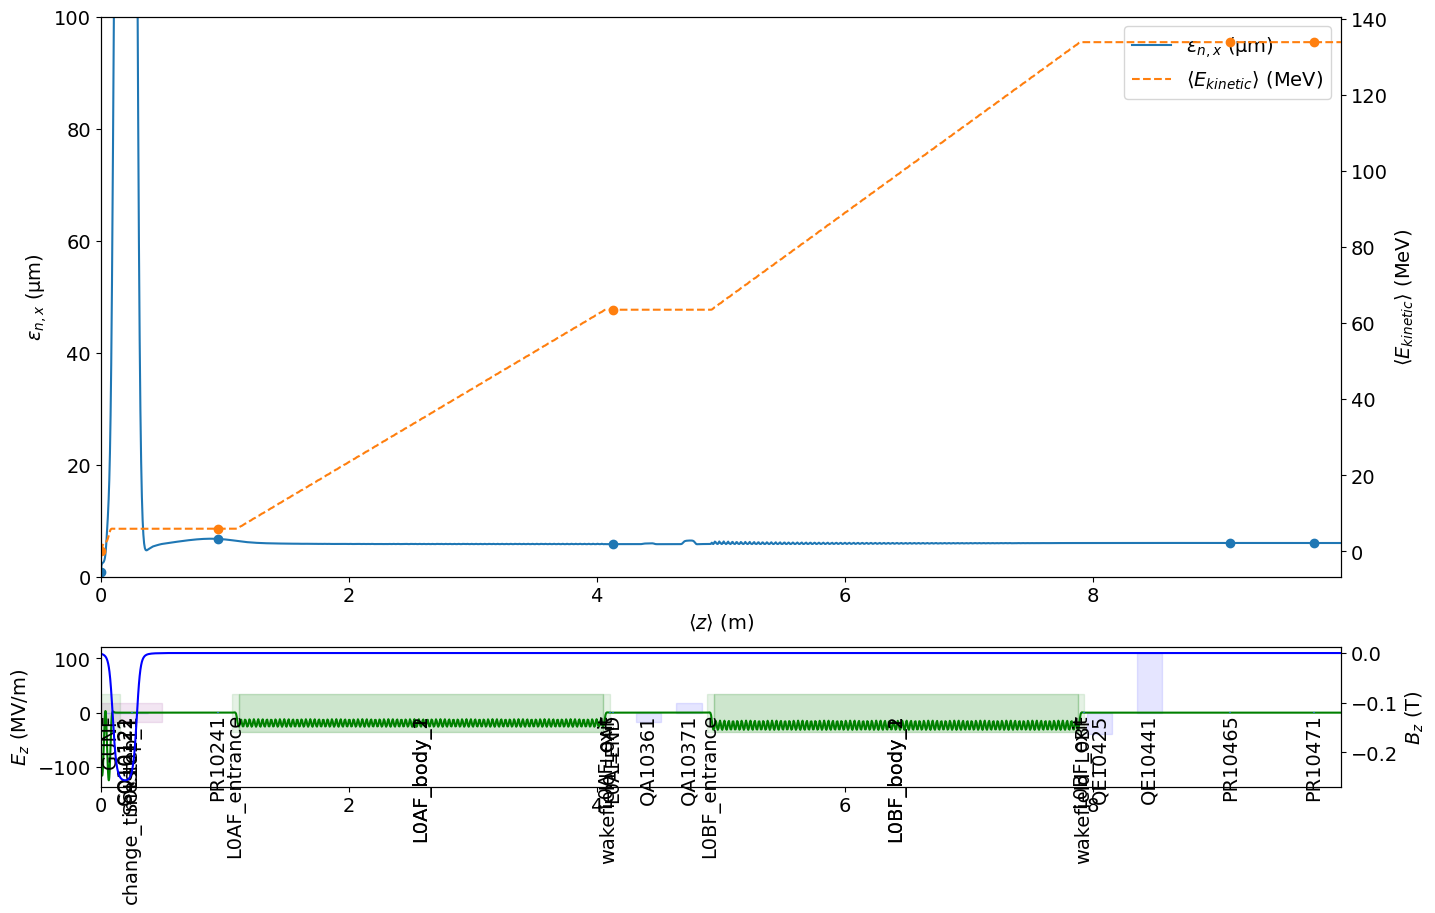

In [51]:
I['group']
I.plot('norm_emit_x', y2='mean_kinetic_energy', ylim=(0, 100e-6), figsize=(16,10), include_labels=True)

In [52]:
P1 = I.particles['PR10241']
P2 = I.particles['L0AFEND']
P3 = I.particles['PR10571']

P1.plot('x', 'y')

KeyError: 'PR10571'

0.12727791290280677
0.34340800399581
0.491278296094794


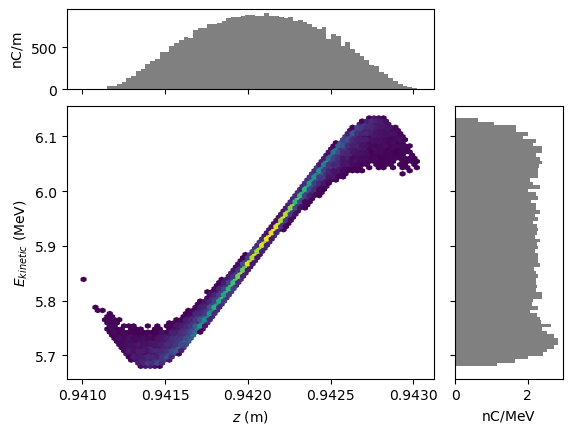

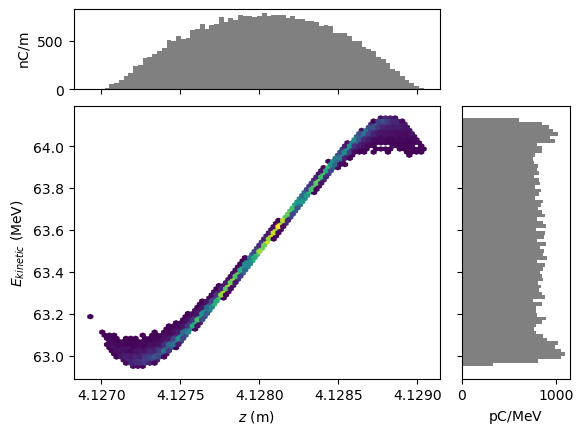

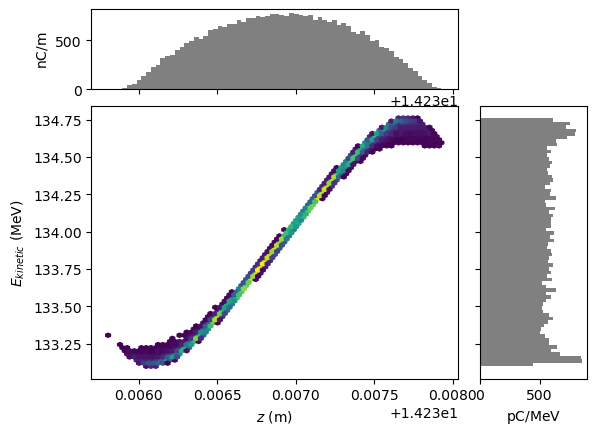

In [18]:

P1.plot('z', 'kinetic_energy')
# ax=plt.gca()
# axlims=ax.get_xlim()

print(np.std(P1['kinetic_energy'])/1e6)
print(np.std(P2['kinetic_energy'])/1e6)
print(np.std(P3['kinetic_energy'])/1e6)

P2.plot('z', 'kinetic_energy')

P3.plot('z', 'kinetic_energy')

# Ready for Bmad

In [19]:
# P1 = I.particles['L0AFEND'].copy()
# P1 = P1.resample(100_000)
# P1.drift_to_z()
# P1.z[:] = 0
# P1.t[:] -= P1['mean_t']
# P1['mean_energy']
# bfile = os.path.expandvars('./L0AFEND.h5')
# P1.write(bfile)